In [2]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
def createdf(filename): #створення фрейму
    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()
    return(df)

In [4]:
df = createdf("csv//sorted_filled_test.csv")

In [5]:
print(str(df.shape[0]) +" rows x " + str(df.shape[1]) + " columns")
df.head()

16887 rows x 9 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,Subscription Premium Cancel
0,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,"{""Payment Method"":""Debit"",""Tokenized Pay"":""""}",2022-01-19 18:47:45,android,samsung,SM-A716U,0
1,0006869712ec9841dc36234bce245203,MD,Subscription Premium,"{""Start Date"":""2022-01-19"",""Renewal Date"":""202...",2022-01-19 18:48:01,android,samsung,SM-A716U,0
2,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:08,android,samsung,SM-A716U,0
3,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:44,android,samsung,SM-A716U,0
4,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,"{""Make"":""Chevrolet"",""Model"":""Express 3500"",""Co...",2022-01-19 18:50:34,android,samsung,SM-A716U,0


In [53]:
print(df.groupby(['event_name'])['event_name'].count())

event_name
Account History Transaction Details    1576
Account Setup Profile Skip              153
Account Setup Skip                       28
Add Payment Method Failed               140
Add Payment Method Success              876
Add Vehicle Break                       175
Add Vehicle Failed                        5
Add Vehicle Success                     908
Calculator Used                          83
Calculator View                         435
Chat Conversation Opened               1244
Chat Conversation Started               986
Email Confirmation Success              249
Order                                  6116
Reset Password Set                        1
Sign Out                                417
Sign Up Error                             5
Sign Up Success                         764
Subscription Premium                    711
Subscription Premium Cancel             271
Subscription Premium Renew              310
Transaction Refund                      102
Wallet Opened        

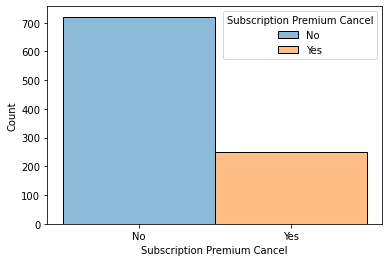

In [6]:
data = copy.deepcopy(df.drop_duplicates(subset = ["userid"]))
def for_hist(row):
    if row["Subscription Premium Cancel"] == 1:
        return "Yes"
    else:
        return "No"
#fig, ax = plt.subplots(figsize=(15,15))  
data["Subscription Premium Cancel"] = data.apply(for_hist, axis=1)
sns.histplot(data = data, x = "Subscription Premium Cancel", hue = "Subscription Premium Cancel")
plt.show()

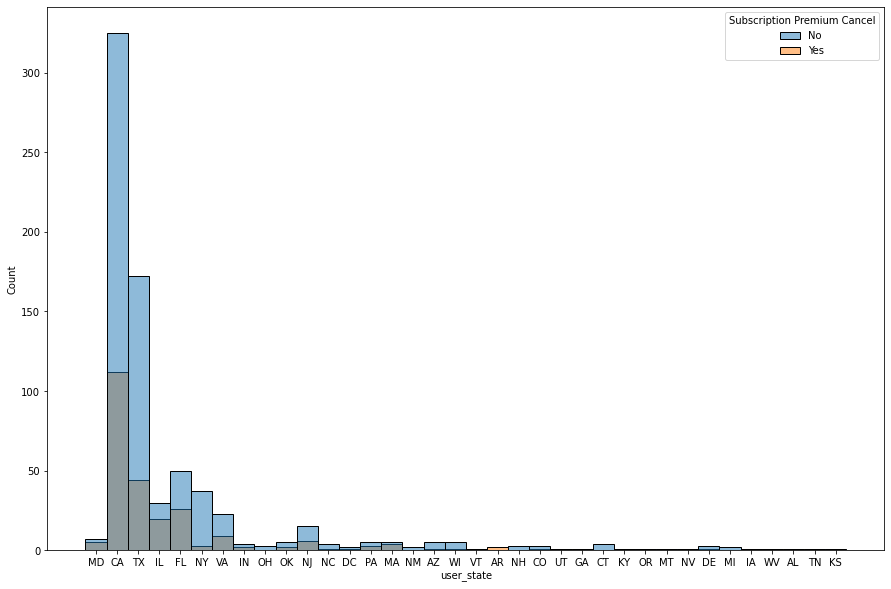

In [7]:
fig, ax = plt.subplots(figsize=(15,10))    
sns.histplot(data = data, x = "user_state", hue = "Subscription Premium Cancel")
plt.show()

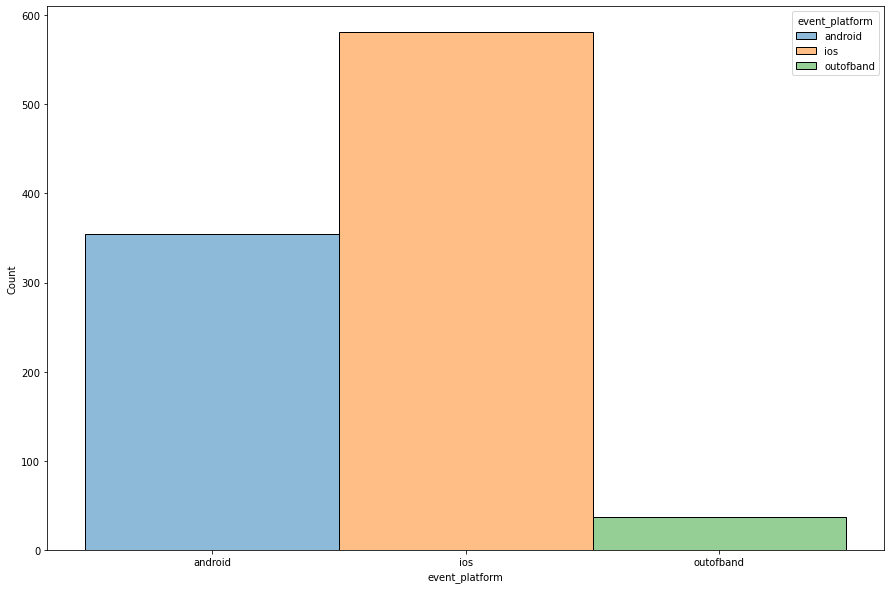

In [8]:

fig, ax = plt.subplots(figsize=(15,10))    
sns.histplot(data = data, x = "event_platform", hue = "event_platform")
plt.show()

In [56]:
df_static_data = createdf("csv//static_data.csv")

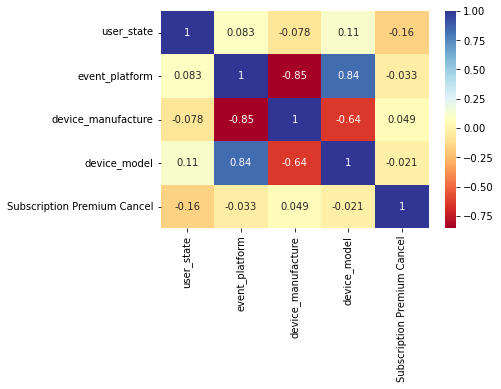

In [57]:
dataplot = sns.heatmap(df_static_data.corr(), cmap="RdYlBu", annot=True)
plt.show()

Певна кореляція зі штатом є, немає ніякої кореляції із використаною платформою чи девайсом.

In [9]:
df_date = createdf("csv//event_and_date_data.csv")

In [10]:
df_error_rate = createdf("csv//error_data.csv")
df_error_rate = df_error_rate.iloc[: , :-5]


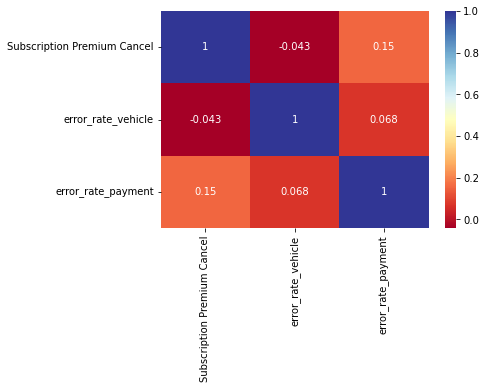

In [11]:
dataplot = sns.heatmap(df_error_rate.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [ ]:
Є невелика кореляція з невдалими спробами додати оплату. 

In [ ]:
Висновок: найменш корельованими показниками є девайс та його виробник, найбільш впливовими - 